In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 2.1

In [54]:
training_data = np.loadtxt('./data/D2z.txt')

x_test = np.arange(-2, 2.1, 0.1)
y_test = np.arange(-2, 2.1, 0.1)
test_points = np.array([[x,y] for x in x_test for y in y_test])

def euclid_dist(p1, p2):
    dist = np.sqrt(np.sum((p1-p2)**2))
    return dist

def pred_1nn(training_data, test_instance):
    distances = [euclid_dist(test_instance[:2], training_instance[:2]) for training_instance in training_data]
    nearest_neighbor_ind = np.argmin(distances)
    label = training_data[nearest_neighbor_ind, 2]
    return label

predictions = np.array([pred_1nn(training_data, test_point) for test_point in test_points])

/tmp/ipykernel_2846662/990105719.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


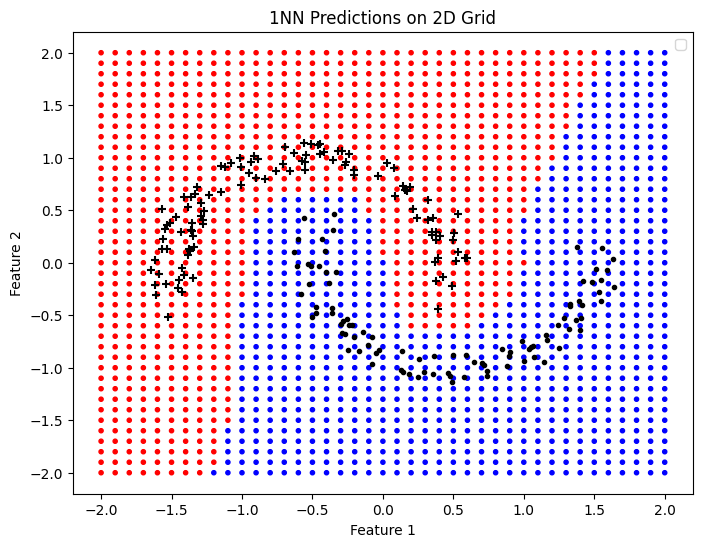

In [64]:
# plt.scatter(training_data[:, 0], training_data[:,1], c=training_data[:,2], marker='+', cmap='bwr', label='Training Set')
plt.figure(figsize=(8, 6))
plt.scatter(test_points[:, 0], test_points[:,1], c=predictions, marker='.', cmap='bwr')
markers = {0: '.', 1: '+'}  # Circle for class 0, square for class 1
for label in np.unique(training_data[:,2]):
    plt.scatter(training_data[training_data[:,2] == label, 0],training_data[training_data[:,2] == label, 1],
                marker=markers[label], c='black')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('1NN Predictions on 2D Grid')
plt.legend()
plt.show()

## 2.2

In [77]:
from sklearn.metrics import roc_curve, auc, precision_score, recall_score
from tqdm import tqdm

def knn(train_data, test_data, k):
    predictions = []
    for test_point in tqdm(test_data):
        distances = []
        for train_point in train_data:
            dist = np.sqrt(np.sum((train_point[:-1]-test_point[:-1])**2))
            distances.append([train_point, dist])
        distances.sort(key=lambda x : x[1])
        neighbors = [x[0] for x in distances[:k]]

        counts = {}
        for neighbor in neighbors:
            label = neighbor[-1]
            if label in counts:
                counts[label] += 1
            else:
                counts[label] = 1
        predicted_label = max(counts, key=counts.get)
        predictions.append(predicted_label)
    accuracy = np.mean(np.array(predictions) == np.array(test_data[:,-1]))

    return accuracy, predictions


In [78]:
data = pd.read_csv('./data/emails.csv')
data = data[data.columns[1:]]
data_np = data.to_numpy()

k_values = [1]
num_folds = 5
fold_size = len(data) // num_folds

avg_metrics = {k: {"accuracy": [], "precision": [], "recall": []} for k in k_values}

for k in k_values:
    for fold in range(num_folds):
        start = fold*fold_size
        end = (fold+1)*fold_size
        test_data = data_np[start:end]
        train_data = np.concatenate((data_np[:start], data_np[end:]))

        accuracy, predictions = knn(train_data, test_data, k)
        precision = precision_score(test_data[:,-1], predictions)
        recall = recall_score(test_data[:,-1], predictions)

        print(accuracy, precision, recall)
        avg_metrics[k]["accuracy"].append(accuracy)
        avg_metrics[k]["precision"].append(precision)
        avg_metrics[k]["recall"].append(recall)

    print(f'k={k}:')
    print(f'  Average Accuracy: {np.mean(avg_metrics[k]["accuracy"]):.3f}')
    print(f'  Average Precision: {np.mean(avg_metrics[k]["precision"]):.3f}')
    print(f'  Average Recall: {np.mean(avg_metrics[k]["recall"]):.3f}\n')

100%|██████████████████████████████████████████████| 1000/1000 [02:35<00:00,  6.43it/s]


0.825 0.6544943820224719 0.8175438596491228


100%|██████████████████████████████████████████████| 1000/1000 [02:08<00:00,  7.81it/s]


0.853 0.6857142857142857 0.8664259927797834


100%|██████████████████████████████████████████████| 1000/1000 [01:58<00:00,  8.45it/s]


0.862 0.7212121212121212 0.8380281690140845


100%|██████████████████████████████████████████████| 1000/1000 [01:43<00:00,  9.65it/s]


0.851 0.7164179104477612 0.8163265306122449


100%|██████████████████████████████████████████████| 1000/1000 [01:47<00:00,  9.31it/s]

0.775 0.6057441253263708 0.7581699346405228
k=1:
  Average Accuracy: 0.833
  Average Precision: 0.677
  Average Recall: 0.819



## 2.3 Logitics Reg

In [137]:
def sigmoid(X, weight):
    z = np.dot(X, weight)
    # print(z)
    return 1 / (1 + np.exp(-z))
    
def gradient_ascent(X, h, y):
    return np.dot(X.T, y - h)
    
def update_weight_mle(weight, learning_rate, gradient):
    return weight + learning_rate * gradient
    
def predict(X, weights):
    print(X.shape, weights.shape, sigmoid(X, weights).shape, "test")
    if sigmoid(X, weights) >= 0.5:
        return 1
    return 0

def logistic_reg(X_train, y_train, learning_Rate=0.01, epochs=10000):
    m,n = X_train.shape
    theta = np.zeros(n)
    for i in range(epochs):
        
        h = sigmoid(X_train, theta)
        gradient = gradient_ascent(X_train, h, y_train)
        theta = update_weight_mle(theta, learning_Rate, gradient)
    return theta

In [140]:
def k_fold_cross_valid(X, y, k=5):
    m = len(y)
    fold_size = m // k
    
    accuracies = []
    precisions = []
    recalls = []

    for fold in range(k):
        start = fold*fold_size
        end = (fold+1)*fold_size
        test_data = X[start:end,:]
        train_data = np.concatenate((X[:start], X[end:]))
        
        X_train, y_train = train_data[:,:-1], train_data[:,-1]
        X_test, y_test = test_data[:,:-1], test_data[:,-1]

        theta  = logistic_reg(X_train, y_train, 0.01, epochs=1000)
        y_pred = predict(X_test, theta)
    
        accuracy = np.mean(y_pred == y_test)
        precision = np.sum((y_pred == 1) & (y_test == 1)) / np.sum(y_pred == 1)
        recall = np.sum((y_pred == 1) & (y_test == 1)) / np.sum(y_test == 1)

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)

    return accuracies, precisions, recalls

In [141]:
data = pd.read_csv('./data/emails.csv')
X = data.iloc[:, 1:-1].values
y = data['Prediction'].values

# Normalize the data
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Add intercept term (bias) to X
X = np.hstack((np.ones((X.shape[0], 1)), X))

accuracies, precisions, recalls = k_fold_cross_valid(X, y, k=5)
print(f"Accuracies: {accuracies}")
print(f"Precisions: {precisions}")
print(f"Recalls: {recalls}")
print(f"Average Accuracy: {np.mean(accuracies)}")
print(f"Average Precision: {np.mean(precisions)}")
print(f"Average Recall: {np.mean(recalls)}")


(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,) (4000,) tarin


/tmp/ipykernel_2846662/152724587.py:4: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,) (4000,) tarin
(4000, 3000) (3000,)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()